# Analysis of Ed Donner's Model

In this notebook we analyse Ed Donner's model it in detail.
- We include all **2000 test data points** (instead of the first 250 of the course) and calculate the core statistical properties mean, and standard deviation.
- We add the **categories** to the results and also make analyses along this dimension.

In [ ]:
# run this in colab to install the required packages

!pip install -q --upgrade torch==2.5.1+cu124 torchvision==0.20.1+cu124 torchaudio==2.5.1+cu124 --index-url https://download.pytorch.org/whl/cu124
!pip install -q --upgrade requests==2.32.3 bitsandbytes==0.46.0 transformers==4.48.3 accelerate==1.3.0 datasets==3.2.0 peft==0.14.0 trl==0.14.0 matplotlib wandb

In [ ]:
import datetime
import torch

print("=== COLAB RUNTIME ENVIRONMENT ===")
print(f"Date: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Hardware
if torch.cuda.is_available():
    print(f"Machine Type: {torch.cuda.get_device_name()}")
else:
    print("Machine Type: CPU only")

print(f"\n=== SOFTWARE VERSIONS ===")
!uv --version
!uv pip list


=== COLAB RUNTIME ENVIRONMENT ===
Date: 2025-09-28 08:25:24
Machine Type: Tesla T4

=== SOFTWARE VERSIONS ===
uv 0.8.22
Using Python 3.12.11 environment at: /usr
Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget              

In [2]:
# imports

import os
import json
from functools import partial
import re
import math
try:
    from google.colab import userdata
except ImportError:
    pass
from huggingface_hub import login
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, set_seed
from datasets import load_dataset
from peft import PeftModel
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
# Constants

#BASE_MODEL = "meta-llama/Llama-3.2-3B"
PROJECT_NAME = "pricer"
HF_USER = "antonawinkler"

# Data
DATASET_NAME = "antonawinkler/pricer-data-llama"

# Hyperparameters for QLoRA
QUANT_4_BIT = True

%matplotlib inline

# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

In [4]:
# Log in to HuggingFace

try:
    hf_token = userdata.get('HF_TOKEN')
except Exception:
    hf_token = os.environ['HF_TOKEN']

login(hf_token, add_to_git_credential=True)

In [ ]:
DATASET_NAME = f"antonawinkler/pricer-data-llama"
test_data = load_dataset(DATASET_NAME, split="test[:100%]")

In [ ]:
len(test_data)

4588

In [6]:
# pick the right quantization

if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [7]:
# Load the Tokenizer and the Model
def load_fine_tuned_model_and_tokenizer(base_model_name, fine_tuned_model_name, revision=None):
  tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  tokenizer.padding_side = "right"

  base_model = AutoModelForCausalLM.from_pretrained(
      base_model_name,
      quantization_config=quant_config,
      device_map="auto",
  )
  base_model.generation_config.pad_token_id = tokenizer.pad_token_id

  # Load the fine-tuned model with PEFT
  if revision:
    fine_tuned_model = PeftModel.from_pretrained(base_model, fine_tuned_model_name, revision=revision)
  else:
    fine_tuned_model = PeftModel.from_pretrained(base_model, fine_tuned_model_name)
  return fine_tuned_model, tokenizer

In [8]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [9]:
# An improved prediction function takes a weighted average of the top 3 choices
# This code would be more complex if we couldn't take advantage of the fact
# That Llama generates 1 token for any 3 digit number

top_K = 3

def improved_model_predict(prompt, llama_model, tokenizer, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = llama_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      #print('prob', probability)
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [10]:
class Tester:

    def __init__(self, predictor, data, title=None, size=None):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        if size:
          self.size = size
        else:
          self.size = len(data)
        self.guesses = []
        self.categories = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error < 40 or error/truth < 0.2:
            return "green"
        elif error < 80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        category = 'none' #datapoint["category"]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        self.categories.append(category)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def create_from_results(cls, data, title, size, guesses, truths, errors, sles, colors, categories):
        """Create a Tester instance directly from results data."""
        # Create an instance without the normal initialization
        instance = cls.__new__(cls)

        # Set the attributes directly
        instance.title = title
        instance.size = size
        instance.guesses = guesses
        instance.truths = truths
        instance.errors = errors
        instance.sles = sles
        instance.colors = colors

        # These won't be used for charting saved results, but initialize to None for completeness
        instance.predictor = None
        instance.data = None
        instance.categories = categories

        return instance

    def to_json(self):
        """Serialize the tester data to a JSON file."""
        tester_data = {
            "title": self.title,
            "size": self.size,
            "guesses": self.guesses,
            "truths": self.truths,
            "errors": self.errors,
            "sles": self.sles,
            "colors": self.colors,
            "data": list(self.data),
            "categories": self.categories,
        }

        return json.dumps(tester_data)

    def serialize(self, filename):
        """Serialize the tester data to a JSON file."""
        tester_data = {
            "title": self.title,
            "size": self.size,
            "guesses": self.guesses,
            "truths": self.truths,
            "errors": self.errors,
            "sles": self.sles,
            "colors": self.colors,
            "data": list(self.data),
            "categories": self.categories,
        }

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(tester_data, f, ensure_ascii=False, indent=4)

    @classmethod
    def from_json(cls, jsonstr):
        """Deserialize the tester data from a JSON file."""
        tester_data = json.loads(jsonstr)

        return cls.create_from_results(
            data=tester_data["data"],
            title=tester_data["title"],
            size=tester_data["size"],
            guesses=tester_data["guesses"],
            truths=tester_data["truths"],
            errors=tester_data["errors"],
            sles=tester_data["sles"],
            colors=tester_data["colors"],
            categories=tester_data["categories"],
        )

    @classmethod
    def deserialize(cls, filename):
        """Deserialize the tester data from a JSON file."""
        # Read the JSON file
        with open(filename, 'r', encoding='utf-8') as f:
            tester_data = json.load(f)

        return cls.create_from_results(
            data=tester_data["data"],
            title=tester_data["title"],
            size=tester_data["size"],
            guesses=tester_data["guesses"],
            truths=tester_data["truths"],
            errors=tester_data["errors"],
            sles=tester_data["sles"],
            colors=tester_data["colors"],
            categories=tester_data["categories"],
        )


    @classmethod
    def test(cls, function, data):
        tester = cls(function, data)
        tester.run()
        return tester

In [ ]:
fine_tuned_model, tokenizer = load_fine_tuned_model_and_tokenizer("meta-llama/Meta-Llama-3.1-8B", "ed-donner/pricer-2024-09-13_13.04.39", revision="e8d637df551603dc86cd7a1598a8f44af4d7ae36")

In [ ]:
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 5700.6 MB


In [ ]:
tester = Tester(
    partial(improved_model_predict, llama_model=fine_tuned_model, tokenizer=tokenizer),
    test_data, title='ed-donner-with-category',
    size=2000  # size of the test data set of the lecture
)

In [ ]:
tester.run()

In [12]:
# if you want to store/load you data in/from the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tester.serialize("/content/drive/My Drive/pricer_ed_donner_spring25.json")

In [23]:
tester = Tester.deserialize("/content/drive/My Drive/pricer_ed_donner_spring25.json")

Our main focus is the (mean absolute) error. In the course this was 46.67 USD. We now get 53.70 USD! Can this be right?

In [26]:
# convert results to pandas datafame
df_results = pd.DataFrame.from_dict({"errors": tester.errors, "categories": tester.categories})

In [35]:
print(f"{df_results['errors'].mean():.2f}")

53.70


In [36]:
# indeed for the first 250 datapoints, we recover the course's mean error
print(f"{df_results['errors'][:250].mean():.2f}")

46.64


But of course the mean absolute error depends on the datapoints. To get a feel for the deviations here is a histogram with kernel density plot.
Each mean absolute error is caluclated over `averate_over_n_samples` samples.

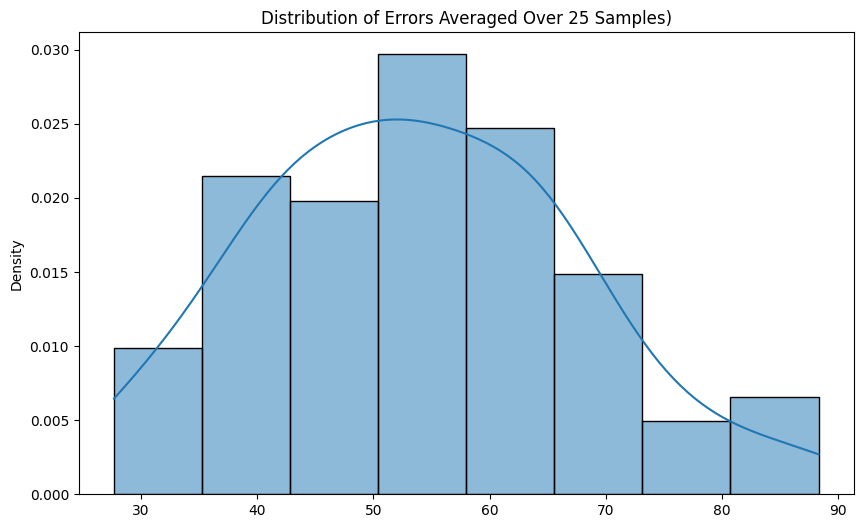

In [37]:
plt.figure(figsize=(10, 6))
averate_over_n_samples = 25
estimator_values = [df_results['errors'][i:i+averate_over_n_samples].mean() for i in range(0, 2000, averate_over_n_samples)]
sns.histplot(estimator_values, kde=True, stat="density", alpha=0.5)
plt.title(f'Distribution of Errors Averaged Over {averate_over_n_samples} Samples)')
plt.show()

In [38]:
std = df_results['errors'].std() / math.sqrt(len(df_results['errors']))
mean = df_results['errors'].mean()
print(f"95 % confidence interval: [mean - 1.96 * std , mean + 1.96 * std] = [{mean - 1.96 * std}, {mean + 1.96 * std}]")

95 % confidence interval: [mean - 1.96 * std , mean + 1.96 * std] = [50.48326694303005, 56.91297219759495]


Let us now analyse the result by category.

In [39]:
df_pivot = df_results.pivot(columns='categories', values='errors')
df_p = pd.DataFrame(df_pivot.mean(), columns=['mean_error'])
df_p['count'] = df_pivot.count()
df_p['std'] = df_pivot.std()
df_p['mean_error_contribution'] = df_p['mean_error'] * df_p['count'] / df_p['count'].sum()
df_p = df_p.sort_values('mean_error_contribution', ascending=False)
df_p

,mean_error,count,std,mean_error_contribution
categories,,,,
Automotive,50.667953,736,68.579187,18.645807
Electronics,70.851395,384,92.552017,13.603468
Tools_and_Home_Improvement,51.833601,469,66.182727,12.154979
Toys_and_Games,42.587800,150,75.697756,3.194085
Office_Products,45.951258,122,63.400246,2.803027
Musical_Instruments,56.406926,80,55.055821,2.256277
Appliances,79.260089,14,91.959622,0.554821
Cell_Phones_and_Accessories,21.584725,45,41.481732,0.485656


We notice that error for electronics is particularly large. This might be a stochastic effect, but it can also indicate that Electronics is a hard problem.
The major contributions to the mean error com from Automotive, Electronics and Tools_and_Home_Improvement.